In [ ]:

"""
"unwrap" abstaction layers of this fast.ai lecture where the author is explaining how to use embeddings
to build a simple recommendation system.

https://github.com/devforfu/pytorch_playground/blob/master/movielens.ipynb

https://medium.com/@iliazaitsev/how-to-implement-a-recommendation-system-with-deep-learning-and-pytorch-2d40476590f9

"""

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import _LRScheduler

plt.style.use('ggplot')

Seed all random generators with the same value to get reproducible results

In [3]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

### Dataset preview

(this is different from the original notebook)

In [4]:
file = "../ml-100k/u.data"

ratings = pd.read_csv(file, sep='\t', header=None)
ratings.columns = "userId movieId rating timestamp".split()
print(ratings.head())

   userId  movieId  rating  timestamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596


In [5]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies"""

    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:n]

    movie_groups = ratings.groupby('movieId')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:n]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_movies, rsuffix='_r', how='inner', on='movieId') )

    return pd.crosstab(top.userId, top.movieId, top.rating, aggfunc=np.sum)

In [6]:
print(tabular_preview(ratings, 10))

movieId  1    50   100  121  181  258  286  288  294  300
userId                                                   
13       3.0  5.0  5.0  5.0  5.0  4.0  3.0  1.0  2.0  1.0
234      3.0  4.0  4.0  NaN  3.0  2.0  3.0  3.0  3.0  3.0
276      5.0  5.0  5.0  4.0  5.0  5.0  NaN  4.0  4.0  4.0
303      5.0  5.0  5.0  3.0  5.0  4.0  5.0  4.0  4.0  1.0
393      3.0  5.0  1.0  4.0  4.0  4.0  NaN  3.0  4.0  NaN
405      NaN  5.0  NaN  NaN  5.0  NaN  NaN  5.0  NaN  NaN
416      5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  4.0  4.0
450      4.0  5.0  4.0  3.0  4.0  4.0  4.0  3.0  4.0  4.0
537      2.0  4.0  4.0  1.0  2.0  4.0  3.0  2.0  1.0  1.0
655      2.0  4.0  3.0  3.0  3.0  2.0  3.0  3.0  3.0  3.0


### Dataset preparation

In [7]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()

    print(ratings.shape)

    unique_users = ratings['userId'].unique()
    user_to_index = {old:new for new, old in enumerate(unique_users)}
    new_users = ratings['userId'].map(user_to_index)

    unique_movies = ratings['movieId'].unique()
    movie_to_index = {old:new for new, old in enumerate(unique_movies)}
    new_movies = ratings['movieId'].map(movie_to_index)

    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]

    X = pd.DataFrame({'user_id':new_users, 'movie_id':new_movies})
    y = ratings['rating'].astype(np.float32)
    #print(type(y))
    return (n_users, n_movies), (X,y), (user_to_index, movie_to_index)

In [8]:
(n,m), (X,y), _ = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f"Dataset shape: {X.shape}")
print(f"Target shape: {y.shape}")

(100000, 4)
Embeddings: 943 users, 1682 movies
Dataset shape: (100000, 2)
Target shape: (100000,)


In [9]:
class ReviewIterator:
    def __init__(self, X, y, batch_size=32, shuffle=True):
        # X is a DF, y is a Series
        X, y = np.asarray(X), np.asarray(y)

        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]

        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k+1)*bs], self.y[k*bs:(k+1)*bs]

In [10]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1,1)

In [11]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[505, 361],
        [512, 364],
        [ 47, 471],
        [896, 298]])
tensor([[5.],
        [5.],
        [5.],
        [4.]])


## Embeddings

In [12]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    Args:
        n_users = Number of unique users in the dataset.
        n_movies = Number of unique movies in the dataset.
        n_factors = Number of columns in the embedding matrix
        embedding_dropout = Dropout rate to apply right after embeddings layer
        hidden = A single integer or a list of integers defining the number of units in hidden layer(s)
        dropouts = A single integer or a list of integer defining the dropout layer rates applyied right after each of
            hidden layers
    """

    def __init__(self, n_users, n_movies, n_factors=50, embedding_dropout=0.02, hidden=10, dropouts=0.2):
        super(EmbeddingNet, self).__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]

        def gen_layers(n_in):
            """

            A generator that yields a sequence of hidden layers and their activations/dropouts.
            Note that the function captures 'hidden' and 'dropouts' values from the outer scope.

            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)

            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0:
                    yield nn.Dropout(rate)
                n_in = n_out

        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()

    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5

        return out

    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values
        """
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)

def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuration should be a single number of a list of numbers')

### Example, create a network with a single hidden layer and dropout, we can use the following

In [13]:
EmbeddingNet(n, m, n_factors=150, hidden=100, dropouts=0.5)

EmbeddingNet(
  (u): Embedding(943, 150)
  (m): Embedding(1682, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

### Example, create three layers

In [14]:
EmbeddingNet(n, m, n_factors=150, hidden=[100, 200, 300], dropouts=[0.25, 0.5])

EmbeddingNet(
  (u): Embedding(943, 150)
  (m): Embedding(1682, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

# Cyclical Learning Rate (CLR)

The method should return a list of learning rates depending on the current training epoch.

In [15]:
class CyclicLR(_LRScheduler):
    def  __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super(CyclicLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

Define scheduling functions.

In [16]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1-x))

        if method == 'triangular':
            pass
        elif method == 'triangular2':
            delta /= float(2 ** (cycle-1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
        return base_lr + delta
    return scheduler

In [17]:
def cosine(t_max, eta_min=0):
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1+math.cos(math.pi*t/t_max))/2
    return scheduler

To understand how the functions work, and to check the correctnes let's plot them

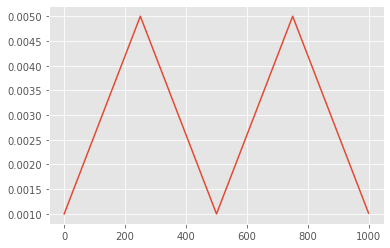

In [18]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

plot_lr(triangular(250, 0.005))

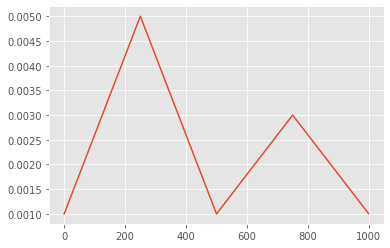

In [19]:
plot_lr(triangular(250, 0.005, 'triangular2'))

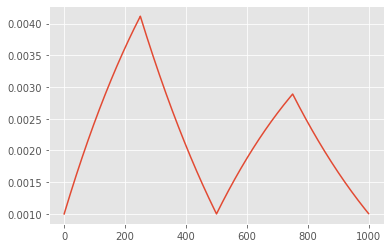

In [20]:
plot_lr(triangular(250, 0.005, 'exp_range', gamma=0.999))

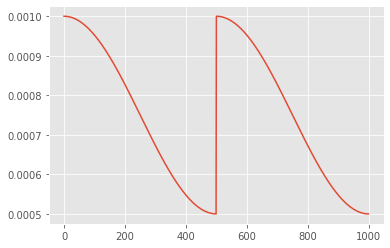

In [21]:
plot_lr(cosine(t_max=500, eta_min=0.0005))

## Training Loop

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train':(X_train, y_train), 'val':(X_valid, y_valid)}
dataset_sizes = {'train':len(X_train), 'val':len(X_valid)}

In [23]:
minmax = ratings['rating'].min().astype(float), ratings['rating'].max().astype(float)
print(minmax)

(1.0, 5.0)


In [44]:
net = EmbeddingNet(n_users=n, n_movies=m, n_factors=50, hidden=[500, 500, 500],
                   embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

*   preparing and running the training loop with cyclical learning rate, validation and early stopping

*   Adam optimizer with cosine-annealing learning rate. The rate is decreased on each batch during 2 epochs,
and then is reset to the original value.

* **train**:update our network's weights and change the learning rate.

* **val**: to check the model's performance

* When the loss value decreases, we save model parameters to restore them later.

* If there is no improvements after 10 sequential training epochs, we exit from the loop.

In [45]:
lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 100
patience = 10       # times before stoping
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))

scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch*2, eta_min=lr/10))


for epoch in range(n_epochs):
    stats = {'epoch': epoch+1, 'total':n_epochs}

    for phase in ('train', 'val'):
        training = phase == 'train'  # This is True | False for train
        running_loss = 0.0
        n_batches = 0

        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()

            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
                loss = criterion(outputs, y_batch)

                # Don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())

            running_loss += loss.item()

        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss

        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print(f"loss improvement on epoch: {epoch+1}")
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements +=1

    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train loss: {train:.4f} - val loss: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

/media/eduardo/SSD_DATA/Appl ML Projects/venv/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss improvement on epoch: 1
[001/100] train loss: 1.2029 - val loss: 1.0198
loss improvement on epoch: 2
[002/100] train loss: 0.9602 - val loss: 0.9470
loss improvement on epoch: 3
[003/100] train loss: 0.9009 - val loss: 0.8964
loss improvement on epoch: 4
[004/100] train loss: 0.8575 - val loss: 0.8901
loss improvement on epoch: 5
[005/100] train loss: 0.8617 - val loss: 0.8858
loss improvement on epoch: 6
[006/100] train loss: 0.8324 - val loss: 0.8828
loss improvement on epoch: 7
[007/100] train loss: 0.8400 - val loss: 0.8780
[008/100] train loss: 0.8129 - val loss: 0.8797
[009/100] train loss: 0.8231 - val loss: 0.8787
[010/100] train loss: 0.8008 - val loss: 0.8822
[011/100] train loss: 0.8085 - val loss: 0.8784
[012/100] train loss: 0.7853 - val loss: 0.8838
[013/100] train loss: 0.7949 - val loss: 0.8848
[014/100] train loss: 0.7674 - val loss: 0.8887
[015/100] train loss: 0.7742 - val loss: 0.8936
[016/100] train loss: 0.7380 - val loss: 0.8997
[017/100] train loss: 0.7447 

## Metrics

In [47]:
print(pd.DataFrame(history).drop(columns='total'))

    epoch     train       val
0       1  1.202916  1.019797
1       2  0.960207  0.947014
2       3  0.900915  0.896351
3       4  0.857470  0.890054
4       5  0.861683  0.885788
5       6  0.832442  0.882823
6       7  0.839998  0.877988
7       8  0.812862  0.879663
8       9  0.823103  0.878668
9      10  0.800793  0.882237
10     11  0.808479  0.878439
11     12  0.785298  0.883765
12     13  0.794867  0.884761
13     14  0.767359  0.888712
14     15  0.774160  0.893589
15     16  0.738040  0.899673
16     17  0.744729  0.904699


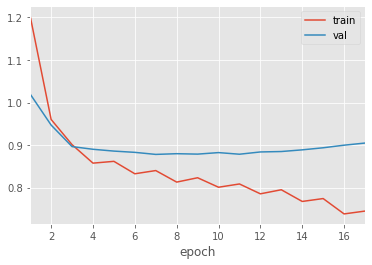

In [48]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

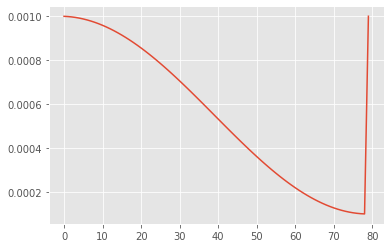

In [49]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])

## Apply the best model to the validation data to see the final performance

In [50]:
ground_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:,1], minmax)
        ground_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

ground_truth = np.asarray(ground_truth).ravel()
predictions = np.asarray(predictions).ravel()

### Final Loss

In [51]:
final_loss = np.sqrt(np.mean((predictions - ground_truth)**2))
print(f"Final RMSE: {final_loss:.4f}")

Final RMSE: 0.9513


In [52]:
with open('best.weights', 'wb') as file:
    pickle.dump(best_weights, file)